In [1]:
import pandas as pd
import tensorflow as tf

In [2]:
import os
train_path = os.path.join('dataset', "train")
test_path = os.path.join('dataset', "test")

In [3]:
#Setting the image height and width
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

In [4]:
#resizing the images in train directory
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_path,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

Found 51120 files belonging to 12 classes.


In [5]:
#resizing the images in test directory
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

Found 3106 files belonging to 12 classes.


In [11]:
train_df = pd.DataFrame(columns=['filename','class'])
for i in os.listdir('dataset/train'):
    filepath='dataset/train/'+i
    for j in os.listdir(filepath):
        train_data = pd.DataFrame({'filename':[j], 'class':[i]})
        #print(train_data)
        train_df = pd.concat([train_df,train_data], ignore_index=True)
train_df

,filename,class
0,paper_aug_799.jpg,paper
1,paper_aug_941.jpg,paper
2,paper_aug_2694.jpg,paper
3,paper_aug_2858.jpg,paper
4,paper_aug_955.jpg,paper
...,...,...
51115,shoes_aug_1030.jpg,shoes
51116,shoes_aug_1024.jpg,shoes
51117,shoes_aug_907.jpg,shoes
51118,shoes526.jpg,shoes


In [11]:
os.listdir('dataset/train')

['paper',
 'green-glass',
 'clothes',
 'metal',
 'cardboard',
 'trash',
 'biological',
 'white-glass',
 'battery',
 'brown-glass',
 'plastic',
 'shoes']

In [ ]:
train_dict = {}
for i in os.listdir('dataset/train'):
    filepath='dataset/train/'+i
    lst=[]
    for j in os.listdir(filepath):
        lst.append(j)
    train_dict[i] = lst
train_dict

In [15]:
len(train_dict['paper'])

4260

In [17]:
test_df = pd.DataFrame(columns=['filename','class'])
for i in os.listdir('dataset/test'):
    filepath='dataset/test/'+i
    for j in os.listdir(filepath):
        test_data = pd.DataFrame({'filename':[j], 'class':[i]})
        test_df = pd.concat([test_df,test_data], ignore_index=True)
test_df

,filename,class
0,paper283.jpg,paper
1,paper526.jpg,paper
2,paper485.jpg,paper
3,paper452.jpg,paper
4,paper320.jpg,paper
...,...,...
3101,shoes1428.jpg,shoes
3102,shoes32.jpg,shoes
3103,shoes254.jpg,shoes
3104,shoes240.jpg,shoes


In [19]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

In [21]:
from tensorflow.keras.applications import VGG16

# Load VGG16 pre-trained on ImageNet without the top (classification) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [23]:
# Freeze the convolutional base so that weights should not get updated during back propogation
#The convolutional layers of VGG16 have already learned generic features
#(like edges, textures, and patterns) from the ImageNet dataset.
for layer in base_model.layers:
    layer.trainable = False

# Need to augment the particular classes and not all classes to balance the data

In [26]:
train_labels = train_dataset.class_names
train_labels

['battery',
 'biological',
 'brown-glass',
 'cardboard',
 'clothes',
 'green-glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash',
 'white-glass']

In [28]:
#counting total number of images in each class.
train_count = {}
for label in train_labels:
    label_path = os.path.join('dataset/train', label)
    count = len(os.listdir(label_path))
    train_count[label] = count

print(train_count)

{'battery': 4260, 'biological': 4260, 'brown-glass': 4260, 'cardboard': 4260, 'clothes': 4260, 'green-glass': 4260, 'metal': 4260, 'paper': 4260, 'plastic': 4260, 'shoes': 4260, 'trash': 4260, 'white-glass': 4260}


In [30]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
classes = np.array(list(train_count.keys()))
samples_per_class = np.array(list(train_count.values()))
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(classes)),  # Provide class indices
    y=np.concatenate([
        np.full(count, idx) for idx, count in enumerate(samples_per_class)
    ])
)
# Convert to a dictionary for Keras
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class Weights:", class_weight_dict)

Class Weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0}


In [ ]:
!pip install opencv-python

In [75]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2

# Target number of images per class (equal to the majority class, clothes)
target_count = train_count['clothes']

# Data augmentation settings
data_augmentation = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Augment classes except for 'clothes'
for class_name, images in train_dict.items():
    if class_name == 'clothes':
        continue

    current_count = train_count[class_name]
    additional_count = target_count - current_count
    num=0

    if additional_count > 0:
        augmented_images = []
        # Generate augmented images
        images = [str(img) for img in images if img is not None]
        for img in images:
            #print(img)
            #print('dataset/train/'+class_name+'/'+img)
            img = cv2.imread(os.path.join('dataset/train/',class_name,img))
            #print(img)
            img = cv2.resize(img, (224, 224))
            #img = img.reshape((1,) + img.shape)
            img = np.expand_dims(img, axis=0)  # Add batch dimension
            augmented_batch = data_augmentation.flow(img, batch_size=1)
            for _ in range(additional_count // len(images) + 1):
                augmented_img = next(augmented_batch)[0]
                num+=1
                save_path = os.path.join('dataset/train/',class_name, f"{class_name}_aug_{num}.jpg")
                cv2.imwrite(save_path, augmented_img)
                augmented_images.append(augmented_img)
                if len(augmented_images) >= additional_count:
                    break

            if len(augmented_images) >= additional_count:
                break

        # Add augmented images to the dataset
        train_dict[class_name].extend(augmented_images)

# Now train_dataset contains augmented images for minority classes
print('stopped')

stopped


In [32]:
#counting total number of images in each class.
train_count = {}
for label in train_labels:
    label_path = os.path.join('dataset/train', label)
    count = len(os.listdir(label_path))
    train_count[label] = count

print(train_count)

{'battery': 4260, 'biological': 4260, 'brown-glass': 4260, 'cardboard': 4260, 'clothes': 4260, 'green-glass': 4260, 'metal': 4260, 'paper': 4260, 'plastic': 4260, 'shoes': 4260, 'trash': 4260, 'white-glass': 4260}


In [34]:
# Class Weights
class_weight_dict = {0: 1.3678350970017636, 1: 1.312288494077834, 2: 2.13213058419244, 
                     3: 1.4523642322097379, 4: 0.24274256651017215, 5: 2.0558316766070246, 
                     6: 1.6814363143631437, 7: 1.2310515873015873, 8: 1.494340077071291, 
                     9: 0.6540691545435379, 10: 1.856523040095751, 11: 1.6678763440860216}
print("Class Weights:", class_weight_dict)

Class Weights: {0: 1.3678350970017636, 1: 1.312288494077834, 2: 2.13213058419244, 3: 1.4523642322097379, 4: 0.24274256651017215, 5: 2.0558316766070246, 6: 1.6814363143631437, 7: 1.2310515873015873, 8: 1.494340077071291, 9: 0.6540691545435379, 10: 1.856523040095751, 11: 1.6678763440860216}


In [36]:
model = Sequential([
    base_model,
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Flatten(),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(12, activation='softmax')  # Adjust to the number of your classes
])

In [38]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [40]:
 model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [42]:
# Early stopping callback
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
model.build(input_shape=(BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 3))

In [44]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         3,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,854,220 (56.66 MB)

 Trainable params: 136,972 (535.05 KB)

 Non-trainable params: 14,717,248 (56.14 MB)

In [88]:
os.makedirs('modes_vgg')

In [46]:
# Checkpoint highest accuracy
#will save the best version of the model with highest accuracy
checkpoint_high_acc = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"{'modes'}/base_model_highest_accuracy.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

# Checkpoint lowest loss
#will save the best version of the model with lowest loss
checkpoint_low_loss = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"{'modes'}/base_model_lowest_loss.keras",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

In [48]:
import time
start_time = time.time()
print('Start Time = ', start_time)
history = model.fit(train_dataset, 
                    epochs=50, 
                    validation_data=test_dataset,
                    callbacks=[checkpoint_high_acc, checkpoint_low_loss, early_stopping],
                   class_weight=class_weight_dict)
end_time = time.time()
print('End Time =', end_time)

Start Time =  1737267834.9852319
Epoch 1/50
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6233 - loss: 3.8243
Epoch 1: val_accuracy improved from -inf to 0.86768, saving model to modes/base_model_highest_accuracy.keras

Epoch 1: val_loss improved from inf to 1.07440, saving model to modes/base_model_lowest_loss.keras
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 4990s 3s/step - accuracy: 0.6233 - loss: 3.8236 - val_accuracy: 0.8677 - val_loss: 1.0744
Epoch 2/50
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7549 - loss: 1.6441
Epoch 2: val_accuracy did not improve from 0.86768

Epoch 2: val_loss improved from 1.07440 to 0.96122, saving model to modes/base_model_lowest_loss.keras
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 5088s 3s/step - accuracy: 0.7549 - loss: 1.6441 - val_accuracy: 0.8677 - val_loss: 0.9612
Epoch 3/50
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7612 - loss: 1.5690
Epoch 3: val_accuracy improved from 0.86768 to 0.87347, saving model to modes/base_model_highest_acc

In [50]:
print('computational_time=',(end_time-start_time)/3600,'hours')

computational_time= 40.11556176695559 hours


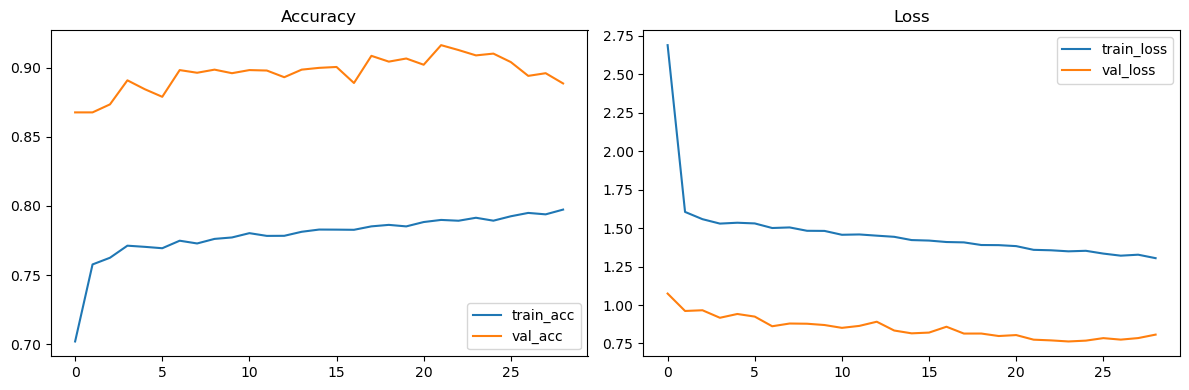

In [52]:
import matplotlib.pyplot as plt
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].plot(train_acc, label="train_acc")
axs[0].plot(val_acc, label="val_acc")
axs[0].set_title("Accuracy")
axs[0].legend()
axs[1].plot(train_loss, label="train_loss")
axs[1].plot(val_loss, label="val_loss")
axs[1].set_title("Loss")
axs[1].legend()

plt.tight_layout()
plt.show()

In [58]:
model.save('vgg16_augmented_model.keras')

In [62]:
model.evaluate()

AttributeError: 'NoneType' object has no attribute 'shape'

In [103]:
import time
start_time = time.time()
print('Start Time = ', start_time)
history = model.fit(train_dataset, 
                    epochs=50, 
                    validation_data=test_dataset,
                    callbacks=[checkpoint_high_acc, checkpoint_low_loss, early_stopping],
                   class_weight=class_weight_dict)
end_time = time.time()
print('End Time =', end_time)

Start Time =  1736946086.526046
Epoch 1/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.5596 - loss: 4.5710 
Epoch 1: val_accuracy improved from -inf to 0.87733, saving model to modes/base_model_highest_accuracy.keras

Epoch 1: val_loss improved from inf to 2.00912, saving model to modes/base_model_lowest_loss.keras
388/388 ━━━━━━━━━━━━━━━━━━━━ 5686s 15s/step - accuracy: 0.5600 - loss: 4.5686 - val_accuracy: 0.8773 - val_loss: 2.0091
Epoch 2/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7979 - loss: 2.1460 
Epoch 2: val_accuracy improved from 0.87733 to 0.88796, saving model to modes/base_model_highest_accuracy.keras

Epoch 2: val_loss improved from 2.00912 to 1.24992, saving model to modes/base_model_lowest_loss.keras
388/388 ━━━━━━━━━━━━━━━━━━━━ 6120s 16s/step - accuracy: 0.7979 - loss: 2.1455 - val_accuracy: 0.8880 - val_loss: 1.2499
Epoch 3/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8029 - loss: 1.5448
Epoch 3: val_accuracy improved from 0.88796 

In [105]:
print('computational_time=',(end_time-start_time)/3600,'hours')

computational_time= 22.559682592749596 hours


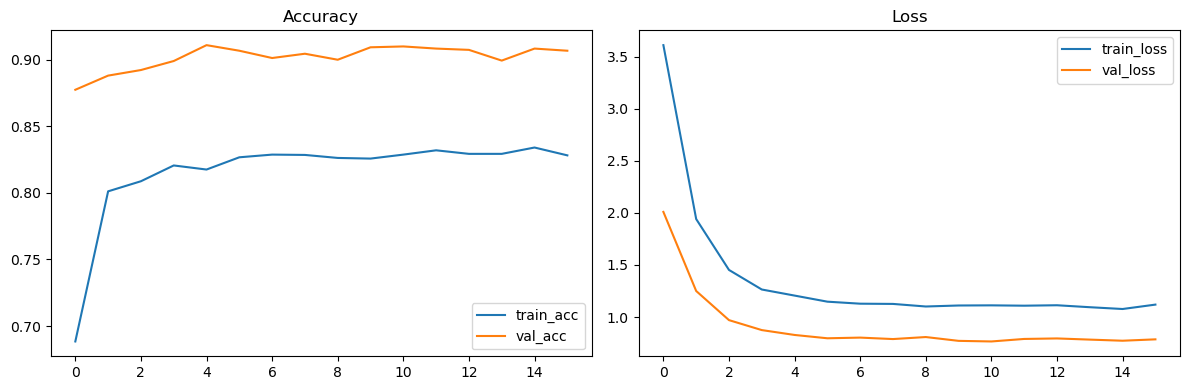

In [107]:
import matplotlib.pyplot as plt
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].plot(train_acc, label="train_acc")
axs[0].plot(val_acc, label="val_acc")
axs[0].set_title("Accuracy")
axs[0].legend()
axs[1].plot(train_loss, label="train_loss")
axs[1].plot(val_loss, label="val_loss")
axs[1].set_title("Loss")
axs[1].legend()

plt.tight_layout()
plt.show()

In [111]:
model.save('vgg16_model.h5')

In [113]:
model.evaluate()

AttributeError: 'NoneType' object has no attribute 'shape'